# Blip 2

[GitHub](https://github.com/salesforce/LAVIS/tree/main/projects/blip2)

[Notebook example](https://github.com/salesforce/LAVIS/blob/main/examples/blip2_instructed_generation.ipynb)

# Install

``` bash
conda create -n blip2 python=3.9
conda activate blip2
conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia
conda install -c anaconda pillow
conda install -y -c anaconda requests
conda install -y -c anaconda jupyter
pip install salesforce-lavis


In [1]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess

## Load an example image

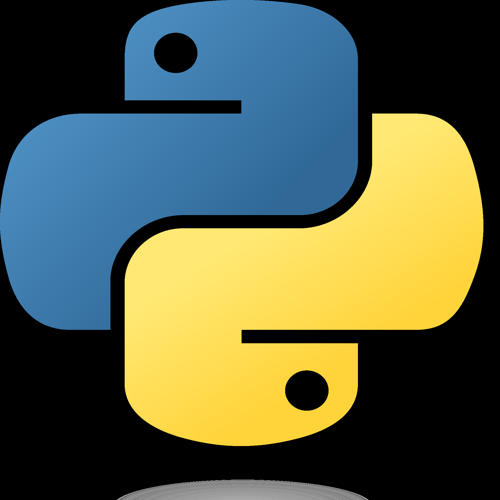

In [2]:
img_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Python-logo-notext.svg/1869px-Python-logo-notext.svg.png'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
display(raw_image.resize((500, 500)))

## setup device to use

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

## we associate a model with its preprocessors to make it easier for inference

In [4]:
# name = "blip2_opt"; model_type = "pretrain_opt2.7b"           # ok
# name = "blip2_opt"; model_type = "caption_coco_opt2.7b"       # FAIL VRAM
# name = "blip2_opt"; model_type = "pretrain_opt6.7b"           # FAIL RAM
# name = "blip2_opt"; model_type = "caption_coco_opt6.7b"       # FAIL RAM

# name = "blip2"; model_type = "pretrain"                       # FAIL type error
# name = "blip2"; model_type = "coco"                           # ok

name = "blip2_t5"; model_type = "pretrain_flant5xl"           # ok
# name = "blip2_t5"; model_type = "caption_coco_flant5xl"       # FAIL VRAM
# name = "blip2_t5"; model_type = "pretrain_flant5xxl"          # FAIL

model, vis_processors, _ = load_model_and_preprocess(
    name=name, model_type=model_type, is_eval=True, device=device
)

vis_processors.keys()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

dict_keys(['train', 'eval'])

## prepare the image as model input using the associated processors

In [5]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

## generate caption using beam search

In [6]:
model.generate({"image": image})

['the python logo on a black background']

## generate multiple captions using nucleus sampling

In [7]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
if name == "blip2" and model_type == "coco":
    model.generate({"image": image}, use_nucleus_sampling=True)
else:
    model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

## instructed zero-shot vision-to-language generation

In [8]:
model.generate({"image": image, "prompt": "What's in the picture? Answer:"})

['python logo']

In [13]:
model.generate({
    "image": image,
    "prompt": "Question: What's in the picture? Answer: singapore. Question: How do you know?"})

['Answer: the python logo is yellow and blue']

In [17]:
context = [
    ("What's in the picture?", "python logo"),
    ("How do you know?", "the python logo is yellow and blue"),
]
question = "What was the basis for calling the language this way?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: What's in the picture? Answer: python logo. Question: How do you know? Answer: the python logo is yellow and blue. Question: What was the basis for calling the language this way? Answer:


In [18]:
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)

['the python logo is yellow and blue']